# Model Evaluation Notebook

# evaluate_model.ipynb


This notebook evaluates a pretrained classifier on validation and test datasets. It computes overall accuracy and plots confusion matrices for each dataset.

## 1. Imports and Setup

In [61]:

# %%
import os
import sys
import yaml
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from safetensors.torch import load_file

# Custom modules (adjust the paths as necessary)
project_root = "/project_ghent/Mostafa/ActivityRecognition/DistInference"
project_root2 = "/project_ghent/Mostafa/ActivityRecognition/DistInference/src/DistInference"
os.chdir(project_root)
sys.path.append(project_root)
sys.path.append(project_root2)

from DistInference.models import My_Model
from DistInference.general_utils import load_config
from DistInference.get_fold_dataloaders import get_dataloaders_from_config

## 2. Set Seed for Reproducibility


In [62]:
def set_seed(seed):
    """
    Set the seed for all relevant libraries to ensure reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

config = load_config("/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml")
seed = config.get('training', {}).get('seed', 42)  # Default to 42 if not specified
set_seed(seed)


## 3. Load Configuration

In [63]:
config_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml"
config = load_config(config_path)

## 6. Load the Pretrained Model

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize the model
model = My_Model(config)

# Path to the pretrained model weights
model_weights_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/model.safetensors"
model_weights_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/20250101_054503/model.safetensors"

# Load the state_dict
state_dict = load_file(model_weights_path)

# Update the model with loaded weights
model.load_state_dict(state_dict)

# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")

Using device: cuda
GPU: NVIDIA A40
Backbone 'resnet50' outputs 2048 features.
Model loaded and set to evaluation mode.


## 7. Prepare Data Loaders

In [65]:
# Function to create data loaders
def get_evaluation_dataloaders(config_path):
    """
    Retrieves validation and test dataloaders along with their datasets.

    Args:
        config_path (str): Path to the configuration file.

    Returns:
        val_loader (DataLoader): DataLoader for the validation set.
        test_loader (DataLoader): DataLoader for the test set.
        val_dataset (Dataset): Validation dataset.
        test_dataset (Dataset): Test dataset.
    """
    # Retrieve all dataloaders; we only need val and test
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, fold_index = get_dataloaders_from_config(config_path)
    return val_loader, test_loader, val_dataset, test_dataset

# Get validation and test loaders
val_loader, test_loader, val_dataset, test_dataset = get_evaluation_dataloaders(config_path)

print("Data loaders for validation and test datasets are ready.")

# %% [markdown]
# ## 8. Define Metrics and Evaluation Function

# %%
def compute_metrics(preds, labels, num_classes):
    """
    Compute accuracy and confusion matrix.

    Args:
        preds (list or np.array): Predicted labels.
        labels (list or np.array): True labels.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    # Compute accuracy
    accuracy = np.mean(np.array(preds) == np.array(labels))
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    
    return accuracy, cm

def evaluate_model(model, dataloader, device, num_classes):
    """
    Evaluate the model on a given dataloader.
    Returns accuracy and confusion matrix.

    Args:
        model (nn.Module): The pretrained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Device to run the evaluation on.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Batch is a list of two tensors: [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            outputs = model(inputs)
            
            # Access 'logits' from the model's output
            if isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            else:
                raise KeyError("Model output does not contain 'logits' key.")
            
            predictions = torch.argmax(logits, dim=-1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy, cm = compute_metrics(all_preds, all_labels, num_classes)
    return accuracy, cm


{'folds_json': 'five_folds.json', 'fold_index': 0, 'train_split_percentage': 0.8, 'batch_sizes': {'train': 512, 'validation': 8, 'test': 1}, 'normalization': 'none', 'force_dim': 314, 'shuffle': {'train': True, 'validation': False, 'test': False}, 'additive_noise_std': {'train': 0.0, 'validation': 0.0, 'test': 0.0}, 'num_workers': {'train': 4, 'validation': 0, 'test': 0}, 'stft': {'window_size': 128, 'overlap': 64}, 'model': {'name': 'resnet50', 'num_classes': 6, 'input_channels': 1, 'learn_order_of_importance': True, 'max_p': 1}, 'training': {'max_steps': 10000.0, 'learning_rate': '8e-4', 'weight_decay': '1e-2', 'logging_steps': 10, 'save_steps': 100, 'evaluation_strategy': 'steps', 'eval_steps': 100, 'save_total_limit': 3}, 'inference': {'noise_level': 0.0}}
Data loaders for validation and test datasets are ready.


/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 9. Evaluate on Validation and Test Sets

In [66]:
num_classes = config['model']['num_classes']

# Evaluate on Validation Set
val_accuracy, val_cm = evaluate_model(model, val_loader, device, num_classes)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on Test Set
test_accuracy, test_cm = evaluate_model(model, test_loader, device, num_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9321
Test Accuracy: 0.9040


## 10. Plot Normalized Confusion Matrix

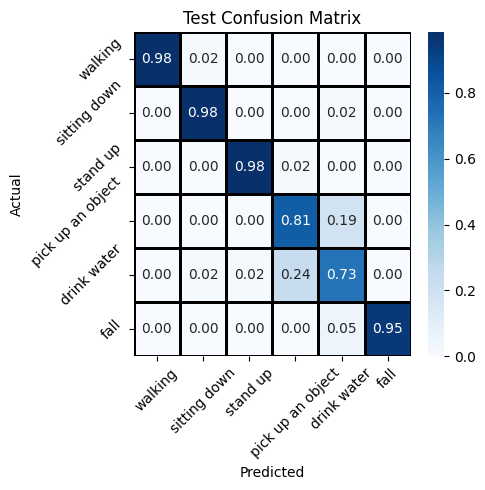

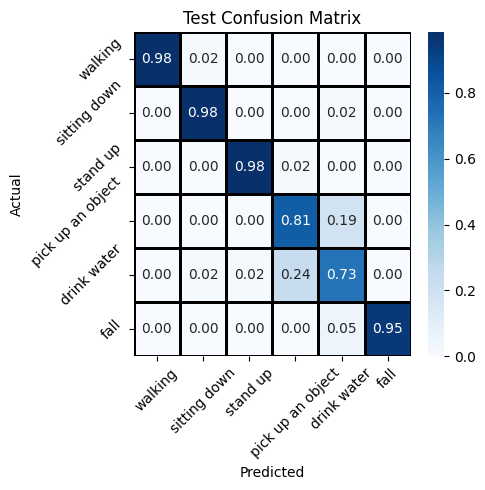

In [67]:
def plot_and_save_normalized_confusion_matrix(cm, class_names, title, filename=None, line_width=1):
    """
    Plot, display, save the normalized confusion matrix, and return the figure.

    Args:
        cm (np.array): Confusion matrix.
        class_names (list): List of class names.
        title (str): Title for the plot.
        filename (str): Filename to save the plot.
        line_width (float): Width of the lines between blocks in the heatmap.

    Returns:
        matplotlib.figure.Figure: The plotted figure.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a new figure
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(
        cm_normalized, annot=True, fmt='.2f', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names,
        linecolor='black', linewidths=line_width, ax=ax
    )
    
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()

    if filename is not None:
        # Save the plot as an image
        plt.savefig(filename)

    # Display the plot
    plt.show()

    return fig


# Label mapping for readability
label_map = {
    0: 'walking',
    1: 'sitting down',
    2: 'stand up',
    3: 'pick up an object',
    4: 'drink water',
    5: 'fall'
}

# Get class labels for the confusion matrix
class_names = [label_map[i] for i in range(len(label_map))]

# Example usage:
# Plot and save Normalized Test Confusion Matrix
plot_and_save_normalized_confusion_matrix(
    test_cm, class_names, "Test Confusion Matrix", "notebooks/test_confusion_matrix.png"
)


# Distributed Inference

In [68]:
import torch
import torch.nn as nn
from timm import create_model

class EdgeModel(nn.Module):
    def __init__(self, original_model):
        super(EdgeModel, self).__init__()
        # Extract layers up to layer4[0]
        self.backbone1 = nn.Sequential(
            original_model.backbone.conv1,
            original_model.backbone.bn1,
            original_model.backbone.act1,
            original_model.backbone.maxpool,
            original_model.backbone.layer1,
            original_model.backbone.layer2,
            original_model.backbone.layer3,
            nn.Sequential(*list(original_model.backbone.layer4.children())[:1])  # layer4[0]
        )
        self.backbone2 = nn.Sequential(
            *list(original_model.backbone.layer4.children())[1:],  # layer4[1] onwards
            original_model.backbone.global_pool,
            original_model.backbone.fc
        )
    def forward(self, x):
        x = self.backbone1(x)
        return self.backbone2(x)



class ServerModel(nn.Module):
    def __init__(self, original_model):
        super(ServerModel, self).__init__()
        
        self.classifier = original_model.classifier
        # If loss_fn is needed on the server side, include it here
        self.loss_fn = original_model.loss_fn
    
    def forward(self, x):
        x = self.classifier(x)
        return x


In [69]:
original_model = model

edge_model = EdgeModel(original_model)
server_model = ServerModel(original_model)

# Move models to appropriate devices
edge_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Edge device
server_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Server device

edge_model.to(edge_device)
server_model.to(server_device)

# Set models to evaluation mode
edge_model.eval();
server_model.eval();


In [70]:
def edge_forward(edge_model, input_tensor):
    with torch.no_grad():
        output = edge_model(input_tensor)
    return output

import io

def serialize_tensor(tensor):
    buffer = io.BytesIO()
    torch.save(tensor, buffer)
    buffer.seek(0)
    return buffer.read()

# Transmit 'serialized_output' to the server via your preferred method (e.g., HTTP, gRPC, WebSocket)

def deserialize_tensor(serialized_data, device):
    buffer = io.BytesIO(serialized_data)
    tensor = torch.load(buffer, map_location=device)
    return tensor

def server_forward(server_model, tensor):
    with torch.no_grad():
        output = server_model(tensor)
    return output

import gzip

def compress_data(data):
    return gzip.compress(data)

def decompress_data(data):
    return gzip.decompress(data)

In [71]:

# Example usage
input_tensor = torch.randn(1, 1, 224, 224).to(edge_device)  # Example input
edge_output = edge_forward(edge_model, input_tensor)

edge_output = edge_output.half()  # Convert to float16
edge_output = edge_output.float()  # Convert back to float32

serialized_output = serialize_tensor(edge_output)

# Example reception
received_data = serialized_output  # Replace with actual received data
server_input = deserialize_tensor(received_data, server_device)
server_output = server_forward(server_model, server_input)

# server_output now contains the final predictions

edge_output = edge_output.half()  # Convert to float16

/tmp/ipykernel_90396/1548374923.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(buffer, map_location=device)


In [72]:




compressed_output = compress_data(serialized_output)
# Transmit 'compressed_output' and decompress on the server
decompressed_data = decompress_data(compressed_output)


In [73]:
import torch
import torch.nn as nn
from timm import create_model
import io
import gzip

# Define Edge and Server Models as above...

def serialize_and_compress(tensor):
    buffer = io.BytesIO()
    torch.save(tensor, buffer)
    serialized = buffer.getvalue()
    compressed = gzip.compress(serialized)
    return compressed

def decompress_and_deserialize(data, device):
    decompressed = gzip.decompress(data)
    buffer = io.BytesIO(decompressed)
    tensor = torch.load(buffer, map_location=device)
    return tensor

# Edge Side
input_tensor = torch.randn(1, 1, 224, 224).to(edge_device)  # Example input
edge_output = edge_forward(edge_model, input_tensor)

edge_output = edge_output.half()  # Convert to float16
edge_output = edge_output.float()  # Convert back to float32

compressed_output = serialize_and_compress(edge_output)

# Transmit 'compressed_output' to the server...

# Server Side
received_data = compressed_output  # Replace with actual received data
server_input = decompress_and_deserialize(received_data, server_device)
server_output = server_forward(server_model, server_input)

# server_output can be further processed or returned as predictions
print(server_output)


tensor([[ 5.9293, -5.9945, -1.0171,  2.0404, -9.0080, -0.6048]],
       device='cuda:0')


/tmp/ipykernel_90396/970307309.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(buffer, map_location=device)


In [74]:
def evaluate_distributed_model(edge_model, server_model, dataloader, edge_device, server_device, num_classes):
    """
    Evaluate the distributed model (edge and server) on a given dataloader.
    Returns accuracy and confusion matrix.

    Args:
        edge_model (nn.Module): The edge-side model.
        server_model (nn.Module): The server-side model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        edge_device (torch.device): Device for the edge model.
        server_device (torch.device): Device for the server model.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    edge_model.eval()
    server_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Batch is a list of two tensors: [inputs, labels]
            inputs, labels = batch[0].to(edge_device), batch[1].to(edge_device)

            # Edge-side processing
            edge_output = edge_forward(edge_model, inputs)  # Forward pass on edge model
            edge_output = edge_output.half()  # Convert to float16
            edge_output = edge_output.float()  # Convert back to float32

            # Add noise to the edge output
            noise = torch.randn_like(edge_output) * 0.01  # Small random noise
            edge_output += noise

            # Serialize and compress for transmission to server
            compressed_output = serialize_and_compress(edge_output)

            # Simulate transmission and decompression at the server side
            server_input = decompress_and_deserialize(compressed_output, server_device)

            # Server-side processing
            server_output = server_forward(server_model, server_input)  # Forward pass on server model

            logits = server_output

            # Generate predictions
            predictions = torch.argmax(logits, dim=-1)

            # Collect predictions and labels
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy and confusion matrix
    accuracy, cm = compute_metrics(all_preds, all_labels, num_classes)
    return accuracy, cm


In [75]:
num_classes = config['model']['num_classes']

# Evaluate on Test Set
test_accuracy, test_cm = evaluate_distributed_model(edge_model, server_model, test_loader, 'cuda', 'cuda', num_classes)

print(f"Test Accuracy: {test_accuracy:.4f}")

/tmp/ipykernel_90396/970307309.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(buffer, map_location=device)


Test Accuracy: 0.9040


In [76]:
import torch
import numpy as np
import zlib  # Example lossless compressor
# You could also try bz2, lz4, or any other library

# def quantize_tensor(tensor, num_bits=8):
#     """
#     Uniformly quantize a float32 tensor to `num_bits`.

#     Steps:
#     1. Compute min and max of the tensor.
#     2. Scale and shift the tensor values to [0, 2^num_bits - 1].
#     3. Round and convert to integer.
#     4. Return both the quantized tensor and the min/max for later dequantization.
#     """
#     # For a robust approach, you might want to track running min/max or per-channel min/max
#     # But here we do a naive min-max across the entire tensor.
#     min_val = tensor.min()
#     max_val = tensor.max()
    
#     # Avoid edge cases
#     if min_val == max_val:
#         # If the entire tensor is the same value, we can store just one value
#         # and skip quantization. For simplicity, handle trivially:
#         scale = 1.0
#         zero_point = 0
#         q_tensor = torch.zeros_like(tensor, dtype=torch.int32)
#         return q_tensor, (min_val, max_val, scale, zero_point)
    
#     qmin = 0.
#     qmax = (2 ** num_bits) - 1.
    
#     # Scale and zero point
#     scale = (max_val - min_val) / (qmax)
#     zero_point = min_val

#     # Transform: float -> integer in [0, 2^num_bits - 1]
#     q_tensor = ((tensor - zero_point) / scale).round().clamp_(qmin, qmax).to(torch.int32)

#     # Return quantized tensor plus info needed for dequant
#     return q_tensor, (min_val, max_val, scale, zero_point)

# def dequantize_tensor(q_tensor, quant_info):
#     """
#     Dequantize an integer tensor back to float32 using the stored quant_info.
#     """
#     (min_val, max_val, scale, zero_point) = quant_info
#     # integer -> float
#     f_tensor = (q_tensor.float() * scale) + zero_point
#     return f_tensor

# def serialize_and_compress(tensor, compression='none', num_bits=None):
#     """
#     Serializes and optionally compresses a tensor. 
#     Also supports quantization before compression if num_bits is specified.

#     Args:
#         tensor (torch.Tensor): The data to be serialized.
#         compression (str): 'none' | 'lossless' | 'quant_only' | 'quant_lossless'
#             - 'none': No compression, no quantization.
#             - 'lossless': Apply zlib (or any other) compression only.
#             - 'quant_only': Apply quantization only.
#             - 'quant_lossless': Apply quantization then lossless compression.
#         num_bits (int, optional): If set, quantize to `num_bits`.
    
#     Returns:
#         bytes, optional metadata
#     """
#     # First, move tensor to CPU if needed, then detach
#     tensor_cpu = tensor.detach().cpu()

#     if compression in ['quant_only', 'quant_lossless'] and num_bits is not None:
#         # Quantize
#         q_tensor, quant_info = quantize_tensor(tensor_cpu, num_bits)
#         # Serialize integer data + quant info
#         data_bytes = q_tensor.numpy().tobytes()
        
#         # Optionally apply a lossless compression
#         if compression == 'quant_lossless':
#             data_bytes = zlib.compress(data_bytes)
        
#         # Return bytes plus the quant_info so we can dequantize later
#         return data_bytes, quant_info

#     elif compression == 'lossless':
#         # Serialize original float data
#         data_bytes = tensor_cpu.numpy().tobytes()
#         # Apply zlib compression
#         data_bytes = zlib.compress(data_bytes)
#         return data_bytes, None

#     else:  # 'none'
#         # Serialize original float data with no compression
#         data_bytes = tensor_cpu.numpy().tobytes()
#         return data_bytes, None

# def decompress_and_deserialize(data_bytes, device, compression='none', quant_info=None):
#     """
#     Decompresses and deserializes the data bytes back to a torch.Tensor.
#     Also handles dequantization if needed.
    
#     Args:
#         data_bytes (bytes): Serialized (and possibly compressed) data.
#         device (torch.device): Which device to move the final tensor to.
#         compression (str): 'none' | 'lossless' | 'quant_only' | 'quant_lossless'
#         quant_info (tuple): Needed for dequantization if we used quantization.
    
#     Returns:
#         (torch.Tensor): The reconstructed tensor on `device`.
#     """
#     if compression in ['lossless', 'quant_lossless']:
#         # Decompress
#         data_bytes = zlib.decompress(data_bytes)

#     # If quantized, we need to interpret the data as int32, then dequantize
#     if compression in ['quant_only', 'quant_lossless'] and quant_info is not None:
#         # Rebuild torch int32 tensor
#         q_array = np.frombuffer(data_bytes, dtype=np.int32)
#         # Dequantize
#         q_tensor = torch.from_numpy(q_array).cuda()
#         f_tensor = dequantize_tensor(q_tensor, quant_info)
#         return f_tensor.to(device)
#     else:
#         # No quantization, interpret data as float32
#         f_array = np.frombuffer(data_bytes, dtype=np.float32)
#         f_tensor = torch.from_numpy(f_array)
#         return f_tensor.to(device)

# def apply_bit_budget_allocation(tensor, total_bits):
#     """
#     Allocates a total bit budget across a tensor using naive uniform quantization.

#     Args:
#         tensor (torch.Tensor): The tensor to compress.
#         total_bits (int): Total bits allocated.

#     Returns:
#         data_bytes (bytes), quant_info (tuple)
#     """
#     # Calculate the number of bits per value
#     numel = tensor.numel()
#     bits_per_value = total_bits / numel

#     # Ensure at least 1 bit per value
#     bits_per_value = int(bits_per_value)
#     if bits_per_value < 1:
#         bits_per_value = 1

#     # Perform quantization with the calculated number of bits
#     q_tensor, quant_info = quantize_tensor(tensor, bits_per_value)
#     # print(f'with {bits_per_value} bits per value: {tensor[:4]} -> {q_tensor[:4]}')
#     # Move quantized tensor to CPU and serialize it to bytes
#     data_bytes = q_tensor.cpu().numpy().tobytes()

#     # Optionally compress the serialized bytes (commented out for now)
#     # data_bytes = zlib.compress(data_bytes)

#     return data_bytes, quant_info


import torch
import math

def quantize_tensor(bit_budget, tensor):
    """
    Quantizes a 1D tensor to fit within the specified bit budget, including metadata.

    Parameters:
        bit_budget (int): Total number of bits available for storage, including metadata.
        tensor (torch.Tensor): Input tensor of shape (1, L).

    Returns:
        dict: A dictionary containing 'min_val', 'max_val', 'quantized_values', 'bits_per_element', and 'shape'.
    """
    if tensor.ndim != 2 or tensor.shape[0] != 1:
        raise ValueError("Tensor must have shape (1, L).")

    L = tensor.shape[1]
    metadata_bits = 32 + 32 + 32  # float32 for min, max and int32 for shape (assuming L fits in 32 bits)
    remaining_bits = bit_budget - metadata_bits

    if remaining_bits <= 0:
        raise ValueError("Bit budget too small to store metadata.")

    bits_per_element = remaining_bits // L
    if bits_per_element < 1:
        raise ValueError("Bit budget too small to allocate at least 1 bit per tensor element.")

    # Limit bits_per_element to a reasonable number, e.g., 32
    bits_per_element = min(bits_per_element, 32)

    levels = 2 ** bits_per_element

    min_val = float(tensor.min())
    max_val = float(tensor.max())

    if min_val == max_val:
        # All elements are the same; no need to store multiple levels
        quantized = torch.zeros(L, dtype=torch.uint8)
        return {
            'min_val': min_val,
            'max_val': max_val,
            'quantized_values': quantized,
            'bits_per_element': bits_per_element,
            'shape': tuple(tensor.shape)
        }

    # Normalize tensor to [0, 1]
    normalized = (tensor - min_val) / (max_val - min_val)
    # Quantize to [0, levels - 1]
    quantized = torch.floor(normalized * (levels - 1)).to(torch.int32)

    # Choose appropriate dtype based on bits_per_element
    if bits_per_element <= 8:
        quantized = quantized.to(torch.uint8)
    elif bits_per_element <= 16:
        quantized = quantized.to(torch.int16)
    elif bits_per_element <= 32:
        quantized = quantized.to(torch.int32)
    else:
        raise ValueError(f"Unsupported bits_per_element: {bits_per_element}")

    return {
        'min_val': min_val,
        'max_val': max_val,
        'quantized_values': quantized,
        'bits_per_element': bits_per_element,
        'shape': tuple(tensor.shape)
    }

def dequantize_tensor(quantized_data):
    """
    Dequantizes the tensor from its quantized form.

    Parameters:
        quantized_data (dict): Dictionary containing 'min_val', 'max_val', 'quantized_values',
                               'bits_per_element', and 'shape'.

    Returns:
        torch.Tensor: Dequantized tensor with the original shape.
    """
    min_val = quantized_data['min_val']
    max_val = quantized_data['max_val']
    quantized = quantized_data['quantized_values']
    bits_per_element = quantized_data['bits_per_element']
    shape = quantized_data['shape']

    L = shape[1]  # Since shape is (1, L)

    if min_val == max_val:
        # All elements are the same
        return torch.full(shape, min_val, dtype=torch.float32)

    levels = 2 ** bits_per_element
    normalized = quantized.to(torch.float32) / (levels - 1)
    tensor = normalized * (max_val - min_val) + min_val

    return tensor.view(shape)
    

def evaluate_distributed_model(
    edge_model, 
    server_model, 
    dataloader, 
    edge_device, 
    server_device, 
    num_classes,
    compression='none', 
    num_bits=None, 
    use_bit_budget=False, 
    total_bits=None
):
    """
    Evaluate the distributed model (edge and server) on a given dataloader.
    Returns accuracy and confusion matrix.

    Args:
        edge_model (nn.Module): The edge-side model.
        server_model (nn.Module): The server-side model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        edge_device (torch.device): Device for the edge model.
        server_device (torch.device): Device for the server model.
        num_classes (int): Number of classes.
        compression (str): 'none' | 'lossless' | 'quant_only' | 'quant_lossless'
            - 'none': no compression
            - 'lossless': standard lossless (e.g., zlib)
            - 'quant_only': quantization only
            - 'quant_lossless': quantization then lossless compression
        num_bits (int, optional): Number of bits for quantization (if applicable).
        use_bit_budget (bool): If True, ignore `compression` and `num_bits` 
                               and use a total bit budget approach.
        total_bits (int, optional): Total bits if `use_bit_budget=True`.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    edge_model.eval()
    server_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Batch is a list of two tensors: [inputs, labels]
            inputs, labels = batch[0].to(edge_device), batch[1].to(edge_device)

            # Edge-side forward pass
            edge_output = edge_model(inputs)
            quantized_data = quantize_tensor(total_bits, edge_output)
            

            # # OPTIONAL: convert to half (as in your snippet)
            # # edge_output = edge_output.half()
            # # edge_output = edge_output.float()

            # # Choose a compression scheme
            # if use_bit_budget and total_bits is not None:
            #     # Custom bit-budget approach
            #     data_bytes, quant_info = apply_bit_budget_allocation(edge_output, total_bits)
            #     # For now, we skip further compression, but you could apply it here
            #     # Decompress & deserialize
            #     # (No decompression if not applying a lossless step)
            #     server_input = decompress_and_deserialize(
            #         data_bytes, 
            #         server_device, 
            #         compression='quant_only', 
            #         quant_info=quant_info
            #     )
            #     # print(f'edge_output={edge_output[0, :4]}')
            #     # print(f'server_input={server_input[:4]}')
            # else:
            #     # Use one of the simpler "compression" modes
            #     data_bytes, quant_info = serialize_and_compress(edge_output, compression, num_bits)
            #     server_input = decompress_and_deserialize(data_bytes, server_device, compression, quant_info)

            server_input = dequantize_tensor(quantized_data)
            # Server-side forward pass
            server_output = server_model(server_input)

            # Ensure server_output has a batch dimension
            if server_output.ndim == 1:
                server_output = server_output.unsqueeze(0)  # Add a batch dimension

            # Predictions
            predictions = torch.argmax(server_output, dim=-1)

            # Safeguard against scalar predictions
            if predictions.ndim == 0:
                predictions = predictions.unsqueeze(0)  # Add a batch dimension

            # Debug prints
            # print("Server output shape after adding batch dimension (if needed):", server_output.shape)
            # print("Predictions shape after reshape:", predictions.shape)

            # Extend lists
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Compute metrics (accuracy, confusion matrix)
    accuracy, cm = compute_metrics(all_preds, all_labels, num_classes)
    return accuracy, cm




Test Accuracy: 0.9040


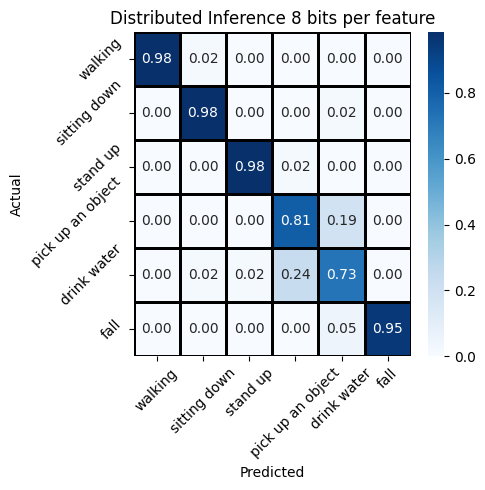

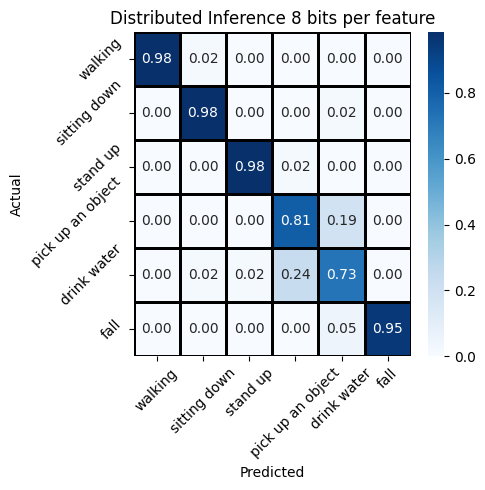

In [77]:
nbits_per_val = 8

# Evaluate on Test Set


test_accuracy, test_cm = evaluate_distributed_model(
    edge_model, 
    server_model, 
    test_loader, 
    'cuda', 
    'cuda', 
    num_classes,
    compression='none', 
    num_bits=None, 
    use_bit_budget=True, 
    total_bits=(2048*nbits_per_val) + 96
)

print(f"Test Accuracy: {test_accuracy:.4f}")

plot_and_save_normalized_confusion_matrix(
    test_cm, class_names, f"Distributed Inference {nbits_per_val} bits per feature")

Test Accuracy for 1 bits per feature: 0.7429


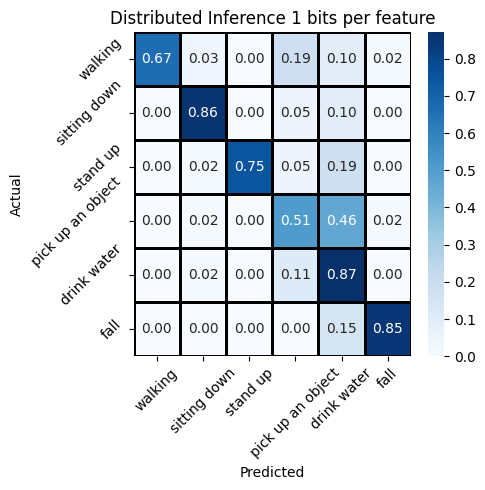

Test Accuracy for 2 bits per feature: 0.9011


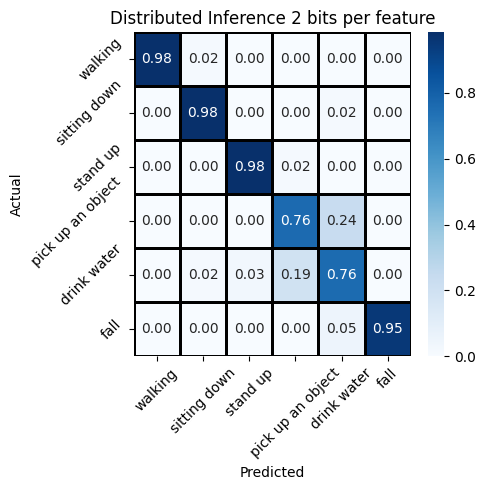

Test Accuracy for 4 bits per feature: 0.8983


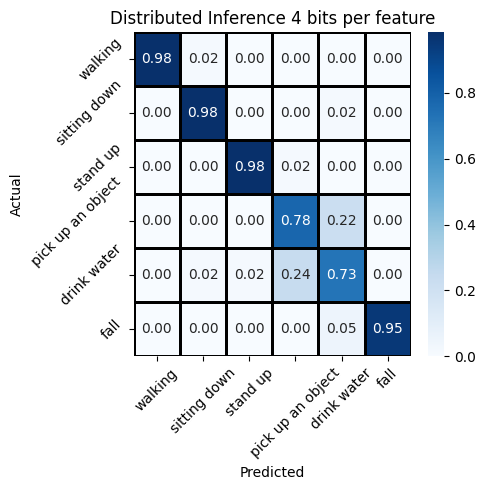

Test Accuracy for 8 bits per feature: 0.9040


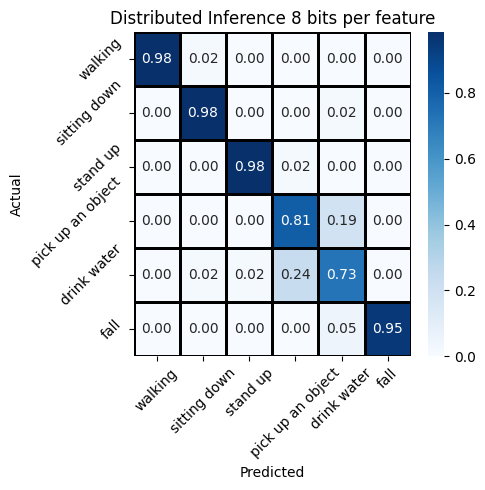

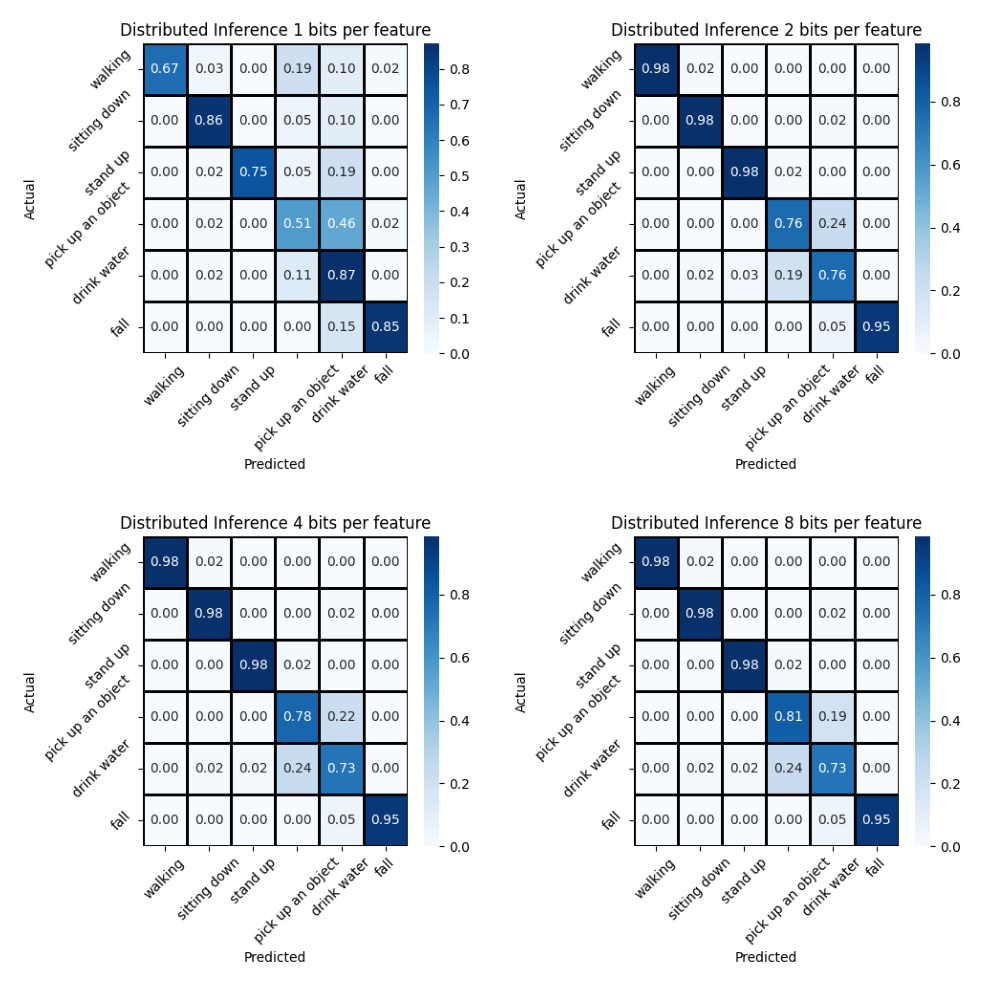

In [78]:
import matplotlib.pyplot as plt

nbits_per_vals = [1, 2, 4, 8]
figs = []

for nbits_per_val in nbits_per_vals:
    # Evaluate on Test Set
    test_accuracy, test_cm = evaluate_distributed_model(
        edge_model, 
        server_model, 
        test_loader, 
        'cuda', 
        'cuda', 
        num_classes,
        compression='none', 
        num_bits=None, 
        use_bit_budget=True, 
        total_bits=(2048 * nbits_per_val) + 96
    )

    print(f"Test Accuracy for {nbits_per_val} bits per feature: {test_accuracy:.4f}")

    fig = plot_and_save_normalized_confusion_matrix(
        test_cm, 
        class_names, 
        f"Distributed Inference {nbits_per_val} bits per feature"
    )
    figs.append(fig)

# Plot a 2x2 grid of the returned figures
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < len(figs):
        figs[i].axes[0].get_figure().tight_layout()  # Adjust layout for each figure
        figs[i].axes[0].figure.canvas.draw()
        ax.imshow(figs[i].canvas.buffer_rgba())
        ax.axis('off')  # Hide axes for clarity

plt.tight_layout()
plt.show()


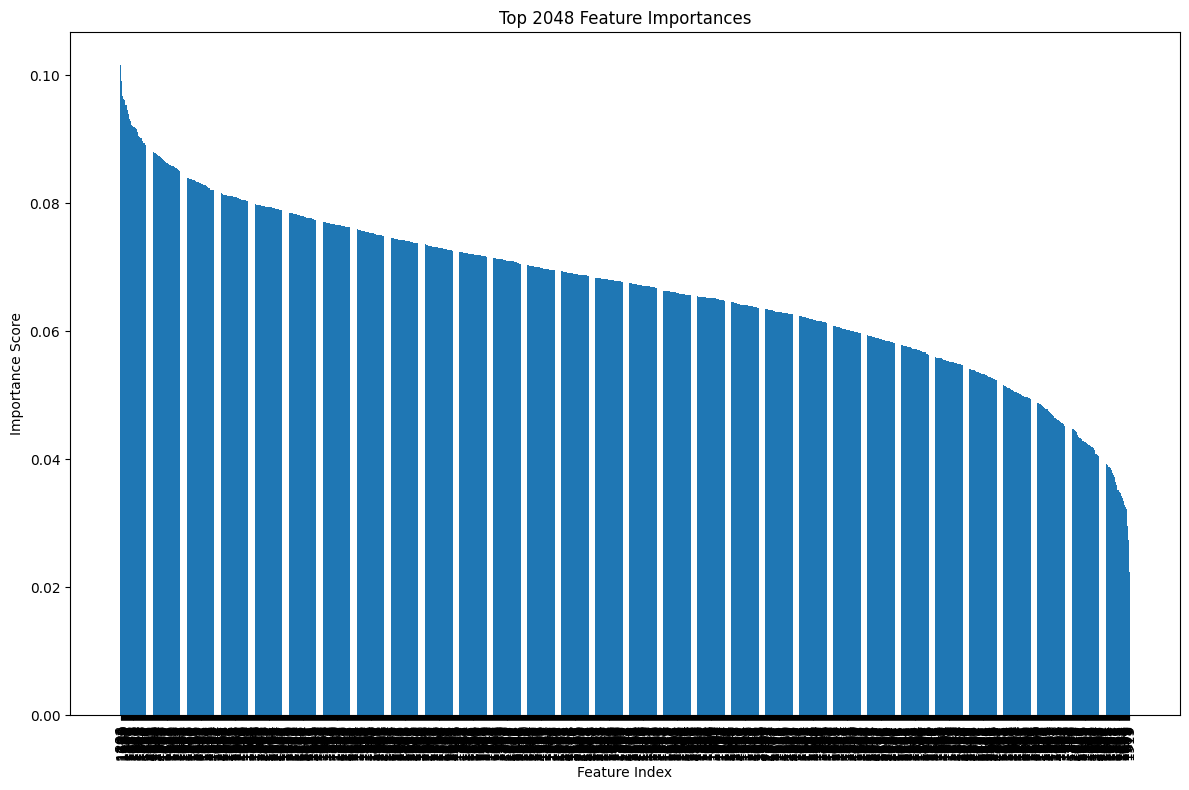

In [85]:

weights = server_model.classifier.weight.data  # Tensor of shape (6, 2048)
# Compute the L2 norm for each feature across the 6 classes
feature_importance = torch.norm(weights, p=2, dim=0)  # Tensor of shape (2048,)
# feature_importance = torch.sum(torch.abs(weights), dim=0)  # Tensor of shape (2048,)

import numpy as np
import matplotlib.pyplot as plt

# Convert the importance tensor to a NumPy array for easier handling
importance = feature_importance.cpu().numpy()

# Get sorted indices in descending order of importance
sorted_indices = np.argsort(importance)[::-1]

# Optional: Select top N features to visualize
top_n = 2048
top_indices = sorted_indices[:top_n]
top_importance = importance[top_indices]

# Plot the top N feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(top_n), top_importance, align='center')
plt.xticks(range(top_n), top_indices, rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()
